In [1]:
# MISC
import os
import sys

sys.path.append("..")
os.environ['MUJOCO_GL']='egl'
os.environ['CUDA_VISIBLE_DEVICES']='1'

# import shutup
# shutup.please()

import jax
import jax.numpy as jnp

import numpy as np
from functools import partial

# VIS
import matplotlib.pyplot as plt
import mediapy
import scienceplots
from rich.pretty import pprint
from tqdm.auto import tqdm

from utils.datasets import GCDataset
from agents.dynamics_aware_iql import GCIQLAgent
from hydra import initialize, compose
from omegaconf import OmegaConf

plt.style.use(['seaborn-v0_8-colorblind', 'seaborn-v0_8-notebook'])

GLOBAL_KEY = jax.random.key(42)

Total trajectories: 3000
Trajectories with hints: 2837
Trajectories without hints: 163
Box 0 revealed: 2188
Box 1 revealed: 297
Box 2 revealed: 352


{
│   'actions': (3000, 100, 1),
│   'item_locations': (3000, 100),
│   'masks': (3000, 100),
│   'next_observations': (3000, 100, 192),
│   'next_states': (3000, 100, 192),
│   'observations': (3000, 100, 192),
│   'rewards': (3000, 100),
│   'states': (3000, 100, 192)
}

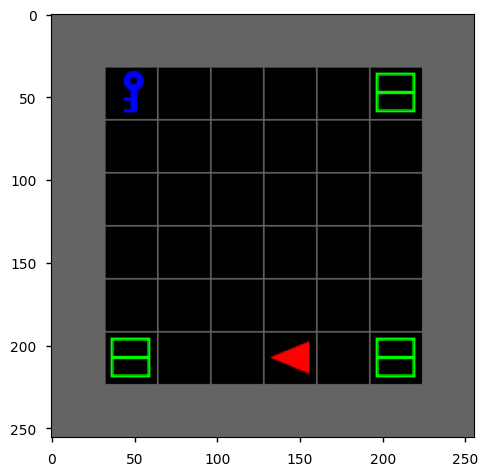

In [ ]:
from envs.new_minigrid.genie import Genie
import gymnasium as gym
from envs.minigrid.env_utils import convert_trajs_to_dict

env = gym.make("MiniGrid-Genie-8x8-v0", disable_env_checker=True)
env = env.unwrapped
env.seed(seed=228)
obs, _ = env.reset()
plt.imshow(env.render())

# # collect data
whole_data = np.load("/home/m_bobrin/ZeroShotRL/envs/new_minigrid/collect_MiniGrid-Genie-8x8.npz", allow_pickle=True)['arr_0'][()]

def classify_trajectories(observations):
    """
    Checks ONLY the Sphinx's tile for hints.
    Assumes Sphinx is at (0, 0) - adjust if different in your env.
    """
    num_episodes = observations.shape[0]
    episode_length = observations.shape[1]
    sphinx_pos = (1, 1)  # Top-left corner (adjust if needed)
    
    revealed_indices = []
    no_hint_indices = []
    box_revealed = {0: [], 1: [], 2: []}
    
    for ep_idx in range(num_episodes):
        revealed_box = None
        
        for t in range(episode_length):
            # Check ONLY the Sphinx's tile
            hint_value = observations[ep_idx, t, sphinx_pos[0], sphinx_pos[1], 1]
            
            if hint_value < 3:
                revealed_box = int(hint_value)
                break  # Stop at first hint
        
        if revealed_box is not None:
            revealed_indices.append(ep_idx)
            box_revealed[revealed_box].append(ep_idx)
        else:
            no_hint_indices.append(ep_idx)
    
    return revealed_indices, no_hint_indices, box_revealed

# Classify all trajectories
revealed_indices, no_hint_indices, box_revealed = classify_trajectories(whole_data['observations'])

# Print statistics
print(f"Total trajectories: {len(whole_data['observations'])}")
print(f"Trajectories with hints: {len(revealed_indices)}")
print(f"Trajectories without hints: {len(no_hint_indices)}")
print(f"Box 0 revealed: {len(box_revealed[0])}")
print(f"Box 1 revealed: {len(box_revealed[1])}")
print(f"Box 2 revealed: {len(box_revealed[2])}")

revealed_obs = {k: whole_data['observations'][v].reshape(-1, 100, 192) for k, v in box_revealed.items()}
revealed_actions = {k: whole_data['actions'][v].reshape(-1, 100, 1) for k, v in box_revealed.items()}
revealed_next_obs = {k: whole_data['next_observations'][v].reshape(-1, 100, 192) for k, v in box_revealed.items()}
no_hint_trajs = whole_data['observations'][no_hint_indices].reshape(-1, 100, 192)


whole_data['observations'] = whole_data['observations'].reshape(-1, 100, 192)
whole_data['next_observations'] = whole_data['next_observations'].reshape(-1, 100, 192)
whole_data['states'] = whole_data['states'].reshape(-1, 100, 192)
whole_data['next_states'] = whole_data['states'].reshape(-1, 100, 192)
whole_data['actions'] = whole_data['actions'][...,None]

pprint(jax.tree.map(lambda x: x.shape, whole_data))

In [36]:
from utils.transformer_nets import DynamicsTransformer, NextStatePrediction
from utils.flax_utils import TrainState, ModuleDict
import optax
from utils.datasets import Dataset
from sklearn.manifold import TSNE

whole_dataset = Dataset.create(**jax.device_get(whole_data))
example_batch = whole_dataset.sample(1)
next_state_pred_def = NextStatePrediction(hidden_dims=(128, 128, 128), out_dim=example_batch['observations'].shape[-1])
dynamics_def = DynamicsTransformer(
    num_layers=2,
    num_heads=1,
    out_dim=8,
    action_dim=example_batch['actions'].shape[-1],
    causal=False,
    emb_dim=64,
    mlp_dim=256,
    dropout_rate=0.0,
    attention_dropout_rate=0.0,
    context_len=example_batch['observations'].shape[1]
)
key, init_rng = jax.random.split(GLOBAL_KEY)
network_tx = optax.chain(
    optax.clip_by_global_norm(1.0), optax.adam(learning_rate=1e-4))
network_info = dict()
network_info.update(
                dynamic_transformer=(dynamics_def, (example_batch['observations'], example_batch['actions'],
                                                    example_batch['observations'], True))
            )
network_info.update(
    next_state_pred=(next_state_pred_def, (example_batch['observations'], example_batch['actions'],
                                           jnp.zeros((1, example_batch['observations'].shape[1], dynamics_def.out_dim))))
)
networks = {k: v[0] for k, v in network_info.items()}
network_args = {k: v[1] for k, v in network_info.items()}
network_def = ModuleDict(networks)
network_params = network_def.init(init_rng, **network_args)['params']
network = TrainState.create(network_def, network_params, tx=network_tx)

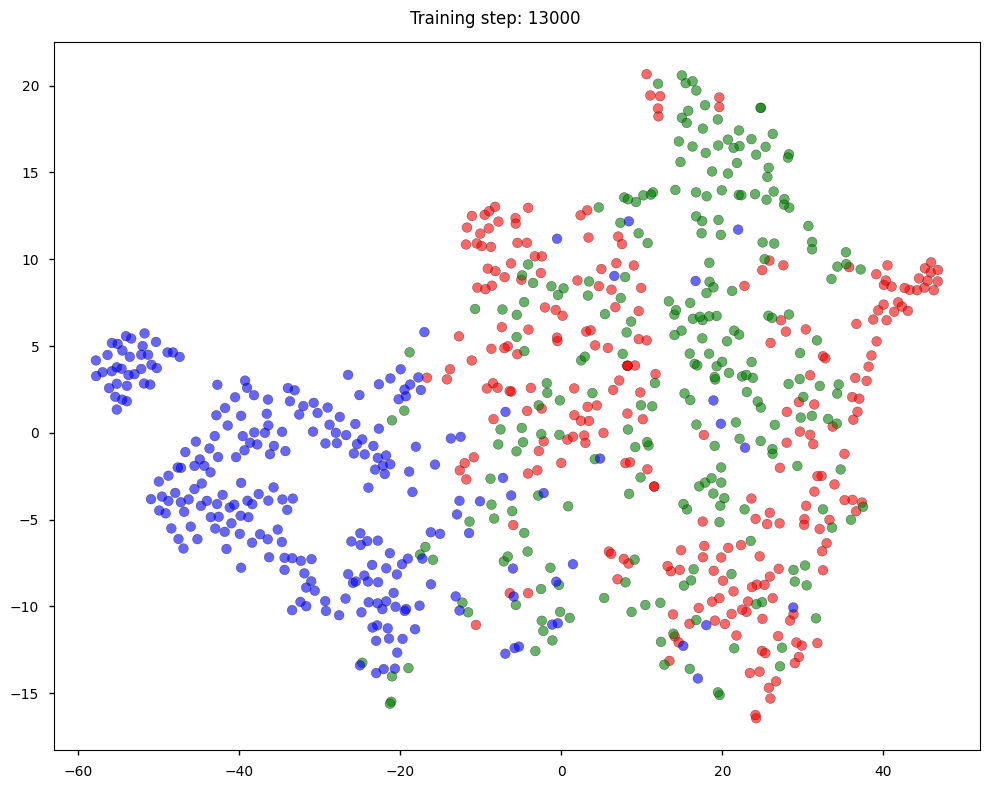

In [ ]:
from IPython.display import clear_output

def context_encoder_loss(agent, batch, grad_params):
    dynamics_embedding = agent.select('dynamic_transformer')(batch['observations'], batch['actions'],
                                                                            batch['next_observations'], train=True, params=grad_params)
    # dynamics_embedding = dynamics_embedding / jax.lax.stop_gradient(jnp.linalg.norm(dynamics_embedding, axis=1, keepdims=True))
    dynamics_embedding = jnp.tile(dynamics_embedding[:, None], reps=(1, batch['next_observations'].shape[1], 1))
    next_state_pred = agent.select('next_state_pred')(batch['observations'], batch['actions'], dynamics_embedding, params=grad_params)
    loss = optax.squared_error(next_state_pred, batch['next_observations']).mean()
    return loss, {"context_embedding_loss": loss}

@jax.jit
def update(agent, batch):
    def loss_fn(grad_params):
        return context_encoder_loss(agent, batch, grad_params)
    
    agent, info = agent.apply_loss_fn(loss_fn)
    return agent, info

box0_obs = revealed_obs[0][:256]
box_0_acts = revealed_actions[0][:256]
box0_nobs = revealed_next_obs[0][:256]

box1_obs = revealed_obs[1][:256]
box_1_acts = revealed_actions[1][:256]
box1_nobs = revealed_next_obs[1][:256]

box2_obs = revealed_obs[2][:256]
box_2_acts = revealed_actions[2][:256]
box2_nobs = revealed_next_obs[2][:256]

all_boxes_obs = np.concatenate([box0_obs, box1_obs, box2_obs])
all_boxes_actions = np.concatenate([box_0_acts, box_1_acts, box_2_acts])
all_boxes_nobs = np.concatenate([box0_nobs, box1_nobs, box2_nobs])

colors = ['red'] * 256 + ['green'] * 256 + ['blue'] * 256

pbar = tqdm(range(50_000))
for i in pbar:
    batch = whole_dataset.sample(512)
    network, info = update(network, batch)
    
    if i % 1_000 == 0:
        clear_output()
        dynamics_embedding = network.select('dynamic_transformer')(all_boxes_obs, all_boxes_actions,
                                                                            all_boxes_nobs, train=False)
        tsne = TSNE(random_state=42).fit_transform(dynamics_embedding)
        fig, ax = plt.subplots(figsize=(10, 8))
        ax.scatter(tsne[:, 0], tsne[:, 1], 
                    edgecolors='black',
                    c=colors,
                    alpha=0.6)

        # ax.legend(title="Environments")
        fig.suptitle(f"Training step: {i}")
        plt.tight_layout()
        display(fig)
        plt.close(fig)

In [37]:
renders = []
env.reset()
reward=0
print(env.item_location)
for i in range(100):
    action = env.action_space.sample()
    obs, rew, done, _ = env.step(action)
    renders.append(
        env.render()
    )
    reward+=rew
print(reward)
mediapy.show_video(
    renders
)

2
-0.6000000000000001
